In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs # .p are the pickled files ...cant be unpickled later

signnames.csv  test.p  train.p	valid.p


In [3]:


import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd #importing from csv file
import random

Using TensorFlow backend.


In [4]:
np.random.seed(0)

In [5]:
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:#rb is reading in binary formatpickle.load
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

# Split out features and labels # split overall data into 3 types
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


In [6]:
#already 4 dimensional
print(X_train.shape) # 34799 imgs of 32X32 pixels each and depth = 3 #rgb
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [7]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

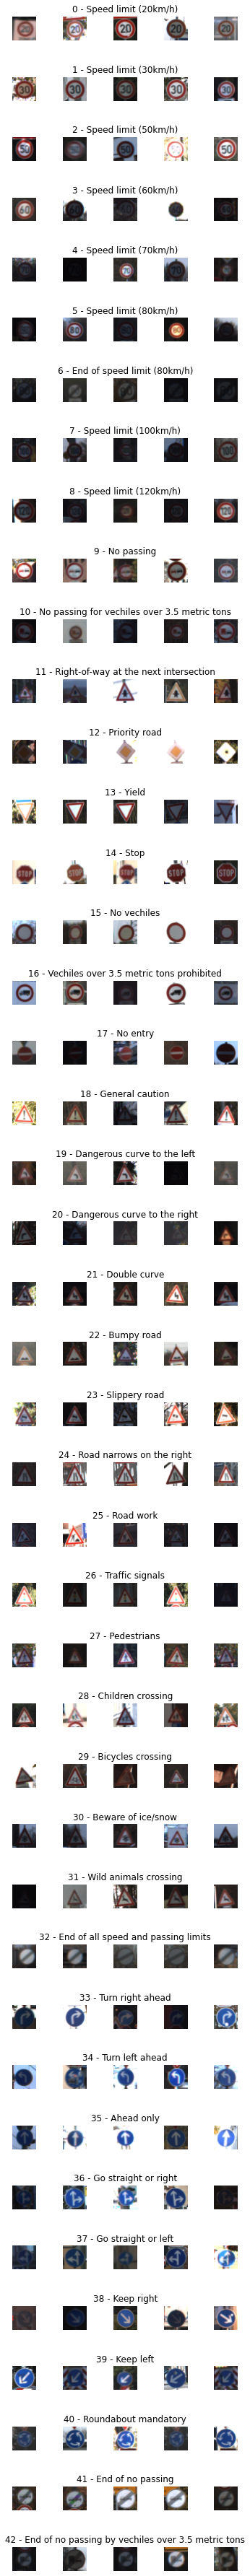

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows(): #iterate through whole data frame as (index,Series)
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


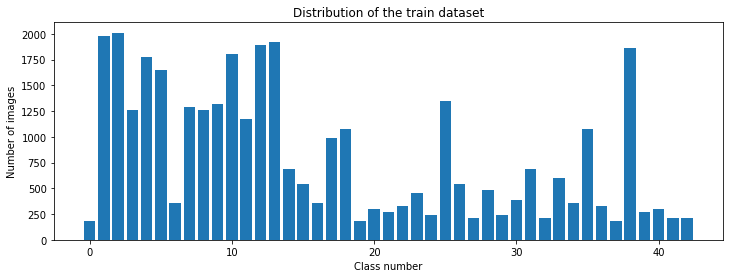

In [9]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


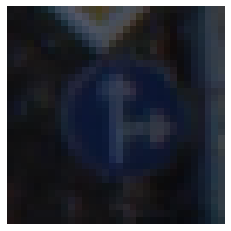

In [10]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


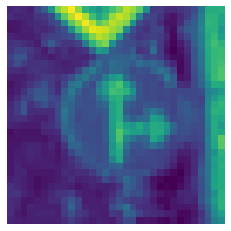

In [11]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000]) 
plt.imshow(img)   
plt.axis("off")
print(img.shape)

(32, 32)


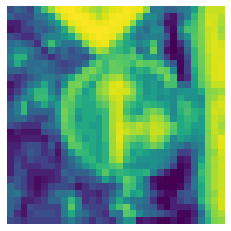

In [12]:
# histogram equalisation # ensures uniform distribution of intensities
def equalize(img):
    img = cv2.equalizeHist(img) #only accept gray scale imgs
    return img
    
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [13]:
# now applying above things for all images
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing, X_train))) #format list into array of imgs
X_test = np.array(list(map(preprocessing, X_test)))
X_val = np.array(list(map(preprocessing, X_val)))   


(34799, 32, 32)


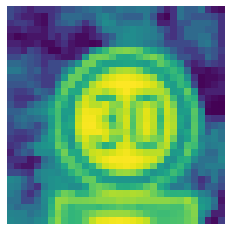

In [14]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)]) # select random image 
plt.axis('off')
print(X_train.shape)

In [15]:
# adding depth (depth in cnn filter....remember....for grayscale depth=1)
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, # max horizontal translation is 10% of img's width
                            height_shift_range=0.1, # ----vertical------------------------------------
                            zoom_range=0.2, # zoom out(as far as 0.8) or zoom in (1.2) #because max =1 and min=-1
                            shear_range=0.1, # shear angle change.....must be small value 
                            rotation_range=10) # can be rotated by 10 degrees
datagen.fit(X_train)                            

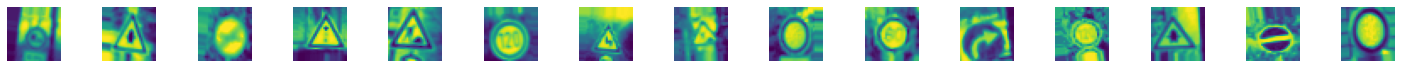

In [17]:
batches = datagen.flow(X_train, y_train, batch_size = 20) 
X_batch, y_batch = next(batches) #retrieves next item for it ....15 new images each time it is called

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

In [18]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [19]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [20]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))  
  
  model.add(Conv2D(30, (3, 3), activation='relu')) # 15*30*3*3 = 4050+15bias params=4065
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) 
  #model.add(Dropout(0.5))
  
  model.add(Flatten()) # while going to fully connected layer this is important
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax')) #output layer 
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [21]:
model = modified_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

In [22]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),steps_per_epoch=2000,epochs=10,validation_data=(X_val, y_val), shuffle = 1)


Epoch 1/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.8534 - accuracy: 0.7517 - val_loss: 0.0663 - val_accuracy: 0.9810
Epoch 2/10
2000/2000 [==============================] - 33s 17ms/step - loss: 0.1936 - accuracy: 0.9388 - val_loss: 0.0825 - val_accuracy: 0.9732
Epoch 3/10
2000/2000 [==============================] - 33s 17ms/step - loss: 0.1358 - accuracy: 0.9578 - val_loss: 0.0477 - val_accuracy: 0.9846
Epoch 4/10
2000/2000 [==============================] - 33s 17ms/step - loss: 0.1064 - accuracy: 0.9676 - val_loss: 0.0396 - val_accuracy: 0.9891
Epoch 5/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.0933 - accuracy: 0.9714 - val_loss: 0.0403 - val_accuracy: 0.9873
Epoch 6/10
2000/2000 [==============================] - 33s 16ms/step - loss: 0.0777 - accuracy: 0.9762 - val_loss: 0.0316 - val_accuracy: 0.9921
Epoch 7/10
2000/2000 [==============================] - 33s 16ms/step - loss: 0.0708 - accuracy: 0.9784 - val_loss: 0.0240 -

Text(0.5, 0, 'epoch')

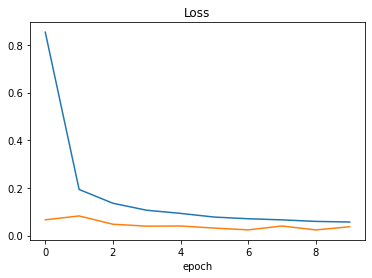

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

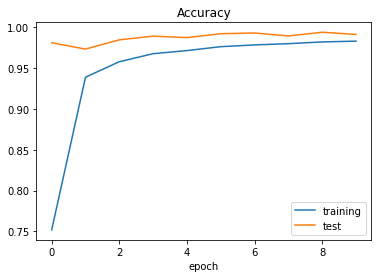

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [25]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# now we must fine tune data as we face two problems:
# less accuracy and overfitting 


Test score: 0.13594075218398158
Test accuracy: 0.9718922972679138


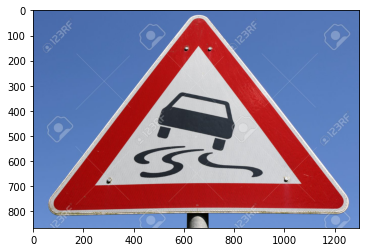

In [50]:
#predict internet number
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


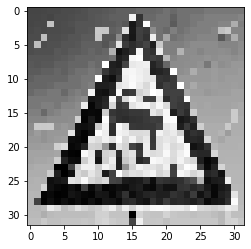

In [51]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32)) #beacuse we trained our NN on 32X32 img
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [52]:
# Reshape img to have a depth 

img = img.reshape(1, 32, 32, 1)

In [53]:
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [23]
